In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as tfk
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from validation.metrics import OME, MSE, get_CV_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from MODELS.ViscNN import load_models, create_ViscNN_concat, create_ViscNN_phys,predict_all_cv, ViscNN_concat_HP,  create_ViscNN_phys_HP
from validation.tests import custom_train_test_split, get_Mw_samples, crossval_NN, Mw_test, evaluate_model, crossval_compare, get_shear_samples, shear_test, small_shear_test, assign_sample_ids
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR, create_GPR
from data_tools.dim_red import fp_PCA
from data_tools.data_viz import val_epochs, calc_slopes_Mw, compare_cv
from data_tools.curve_fitting import *
import datetime
import keras.backend as K
import keras
import random
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-03-30 18:31:15.913172: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-30 18:31:16.674677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18345 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:da:00.0, compute capability: 7.0


In [4]:
data = pd.read_excel('./Data/full_data_03_08_aug.xlsx', na_values = ['nan','','NaN'])
data.columns = [str(c) for c in data.columns]

In [5]:

OG_fp = []
for c in data.columns:
    if isinstance(c, str):
        if 'fp' in c:
            OG_fp.append(c)
len(OG_fp)

219

In [6]:
do_pca = False
if do_pca:
    data, fp_cols, pca = fp_PCA(data, 17, cols = OG_fp)
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
else:
    fp_cols = OG_fp
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']

In [7]:
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

data['PDI'].fillna(2)
data['ZERO_SHEAR'] = 1
data['SHEAR'] = 0
data['log_Shear_Rate'] = 0
for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'log_Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data.loc[i, 'SHEAR'] = 1
        data.loc[i, 'ZERO_SHEAR'] = 0
    if not data.loc[i,'PDI'] > 0:
        data.loc[i,'PDI'] = 2
    if data.loc[i,'PDI'] > 100:
        data.loc[i,'PDI'] = 2
        #data = data.drop([i])

In [8]:
load_data = True
custom = False
full_data = True
date = '2022-03-30'
data_type = 'full_aug'


if full_data:
    train_df = data.sample(frac = 1)
    test_df = data.sample(frac = 1) #dummy df for compatibility
else:
    if load_data:
        train_df = pd.read_pickle(f'MODELS/{date}_{data_type}/train_data.pkl')
        if data_type == 'full':
            test_df = train_df#dummy df for compatibility
        elif data_type == 'full_aug':
            train_df = data.copy()
            test_df = train_df
        else:
            test_df = pd.read_pickle(f'MODELS/{date}_{data_type}/test_data.pkl')
    else: 
        if custom:
            total_samps = len(Mw_ids) + len(shear_ids)
            train_df, test_df = custom_train_test_split(filtered_data, test_id= random.sample(Mw_ids,total_samps//20) + random.sample(shear_ids,total_samps//20), id_col= 'SAMPLE_ID')
        else:
            train_df, test_df = train_test_split(filtered_data, test_size= 0.1)
        
        train_df = train_df.loc[:, (train_df != 0).any(axis=0)]
new_fp = []
for c in train_df.columns:
    if isinstance(c, str):
        if 'fp' in c:
            new_fp.append(c)

if len(OG_fp) != len(new_fp):
    test_df = test_df.drop(columns = list(set(OG_fp) - set(new_fp)))



print(len(train_df))
print(len(test_df))

1961
1961


In [9]:
logMw = np.array(train_df['Mw']).reshape((-1,1))
shear = np.array(train_df['Shear_Rate']).reshape((-1,1))
Temp = np.array(train_df['Temperature']).reshape((-1,1))
Temp = 1/(Temp+273.15)
PDI = np.array(train_df['PDI']).reshape((-1,1))

scaler = MinMaxScaler(copy = False)
XX = np.array(scaler.fit(train_df.filter(fp_cols)).transform(train_df.filter(fp_cols)))
yy = np.array(train_df.loc[:,'Melt_Viscosity']).reshape((-1,1))

y_scaler = MinMaxScaler().fit(yy)
yy = y_scaler.transform(yy);
T_scaler = MinMaxScaler().fit(Temp)
T = T_scaler.transform(Temp);
M_scaler = MinMaxScaler().fit(logMw)
M = M_scaler.transform(logMw);
S_trans = PowerTransformer(standardize = False).fit(shear)
S_scaler = MinMaxScaler().fit(S_trans.transform(shear))
S = S_scaler.transform(S_trans.transform(shear))
P_scaler = MinMaxScaler().fit(PDI)
P = P_scaler.transform(PDI)
#shear = S_scaler.transform((shear))
#gpr_Mcr, mcr_cv_error = Mcr_gpr_train(OG_fp, None, M_scaler, scaler, transform = False)

y_test = y_scaler.transform(np.array(test_df.loc[:,'Melt_Viscosity']).reshape((-1,1)))
X_test = np.array(scaler.transform(test_df.filter(fp_cols)))
M_test = M_scaler.transform(np.array(test_df['Mw']).reshape((-1,1)))
S_test = S_scaler.transform(S_trans.transform(np.array(test_df['Shear_Rate']).reshape((-1,1))))
T_test = np.array(test_df['Temperature']).reshape((-1,1))
T_test = T_scaler.transform(1/(T_test+273.15))
P_test = P_scaler.transform(np.array(test_df['PDI']).reshape((-1,1)))

In [10]:
#XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test, train_ind, test_ind = train_test_split(X_tot, Y_tot,logMw, shear, Temp, range(tot_samples), test_size= 0.1)

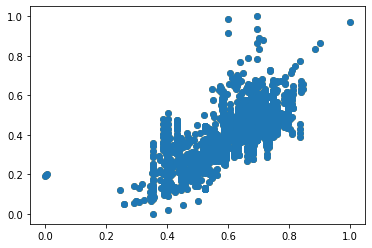

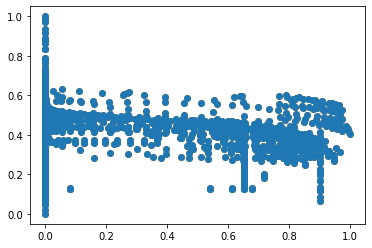

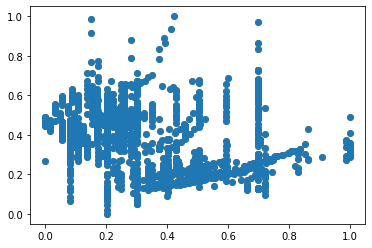

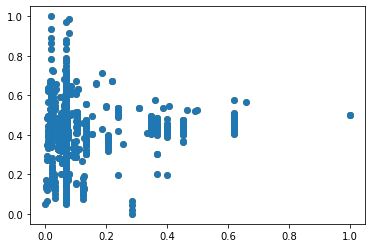

In [12]:
plt.figure()
plt.scatter(M, yy, c = 'orange')
plt.scatter(M_test, y_test)

plt.figure()
plt.scatter(S, yy, c = 'orange')
plt.scatter(S_test, y_test)

plt.figure()
plt.scatter(T, yy, c = 'orange')
plt.scatter(T_test, y_test)

plt.figure()
plt.scatter(P, yy, c = 'orange')
plt.scatter(P_test, y_test)

Reload Models

In [12]:
date = '2022-03-16'
models, history, gpr_models, gp_cv, NN_cv = load_models(date = date, data_type = 'split', NN_models = [create_ViscNN_concat])
#loaded_data = np.load(f'MODELS/{date}_split/data.npz', allow_pickle=True)
#XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test = loaded_data['XX'], loaded_data['X_test'], loaded_data['yy'], loaded_data['y_test'], loaded_data['M'], loaded_data['M_test'], loaded_data['S'], loaded_data['S_test'], loaded_data['T'],loaded_data['T_test']
model_reloaded = True

In [13]:
date = '2022-03-30'
models_f, history_f, gpr_models_f, gp_cv, NN_cv = load_models(date = date, data_type = 'full_aug', NN_models = [create_ViscNN_concat])
model_reloaded = True

In [14]:
Mw_samps, mw_ids = get_Mw_samples(data.copy(), full = True);
shear_samps, shear_ids = get_shear_samples(data.copy())

/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [114]:
extrap_tests = Mw_test(Mw_samps, mw_ids[6])
XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
#print(extrap_tests[samp_num]['tests'])
#Mw_ex = M_scaler.inverse_transform(np.array(extrap_tests['exp'][0]).reshape(-1, 1))
#log_visc_ex = y_scaler.inverse_transform(np.array(extrap_tests['exp'][1]).reshape(-1, 1))
log_visc_ex = np.power(10,extrap_tests['exp'][1])[~np.isnan(np.power(10,extrap_tests['exp'][1]))]
Mw_ex = np.power(10,extrap_tests['exp'][0])[~np.isnan((extrap_tests['exp'][1]))]
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform((XX_ex))
M_ex = M_scaler.transform(M_ex_og)
S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
T_ex = T_scaler.transform(1/(T_ex_og+273.15))
P_ex = P_scaler.transform(P_ex_og)
y_ax = (-2, 11)
temps = [-50, -20, 20, 50]

0         NaN
1         NaN
2   -0.876668
3   -0.363321
4   -0.134576
Name: Melt_Viscosity, dtype: float64


In [ ]:
fig = plt.figure(figsize = (7,10))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
ax = [ax1, ax2]
tick = 0

if model_reloaded:
    test_pred, var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
else:
    test_pred, var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
l = Mw_ex.shape[0]
exp_pred, _ = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex[:l], M_scaler.transform(np.array(Mw_ex).reshape(-1,1)), S_ex[:l], T_ex[:l], P_ex[:l]), axis =1))
exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
fig.suptitle('Zero Shear Visc. GPR Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')

test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1))
var = y_scaler.inverse_transform(np.array(var).reshape(-1, 1)) - y_scaler.data_min_

a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
ax[0].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
ax[0].text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
for temp_test in [False, True]:


    ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
    ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
    ax[tick].axis(ymin = y_ax[0], ymax = y_ax[1])
    ax[tick].scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    #plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
    #plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, [i[0] for i in np.array(var).tolist()], fmt = '-')
    ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - var.reshape(-1,), test_pred.reshape(-1,) + var.reshape(-1,), alpha = 0.3 )

    if temp_test:
        for i in temps:
            test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex), axis = 1))
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            #plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, yerr= test_var,  label = f'Prediction at {T_ex_og[0][0] + i} C')
            ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
            ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

    
    ax[tick].legend()
    tick += 1


In [ ]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
fig = plt.figure(figsize = (7,10))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
ax = [ax1, ax2]
tick = 0
test_pred, test_var,_ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_ex, P_ex])
l = Mw_ex.shape[0]
exp_pred, _,_ = predict_all_cv(models_f[0],[XX_ex[:l], M_scaler.transform(np.array(Mw_ex).reshape(-1,1)), S_ex[:l], T_ex[:l], P_ex[:l]])
exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)

fig.suptitle('Zero Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
ax[0].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
ax[0].text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))

for temp_test in [False, True]:    
    ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
    ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
    # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
    # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
    ax[tick].scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    ax[tick].axis(ymin = y_ax[0], ymax = y_ax[1])
    
    #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
    #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


    ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
    ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - var.reshape(-1,), test_pred.reshape(-1,) + var.reshape(-1,), alpha = 0.3 )

    if temp_test:
        for i in temps:
            test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex])
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
            ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - var.reshape(-1,), test_pred.reshape(-1,) + var.reshape(-1,), alpha = 0.3 )

    ax[tick].legend()
    tick += 1

In [15]:
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/Mw/GPR', exist_ok = True)
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/Mw/ANN', exist_ok = True)
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/shear/GPR', exist_ok = True)
os.makedirs(f'Extrapolation_Tests/{date}_{data_type}/shear/ANN', exist_ok = True)

In [16]:
predicted_constants_gpr = pd.DataFrame(columns = ['Sample', 'a1', 'a2', 'k1', 'k2', 'Mcr'])
for mid in mw_ids:
    extrap_tests = Mw_test(Mw_samps, mid)
    XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    y_ax = (-2, 11)
    temps = [-50, -20, 20, 50]
    
    l = Mw_ex.shape[0]
    test_pred, var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
    test_pred = y_scaler.inverse_transform(np.array(test_pred))

    
    a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a[0] for a in test_pred]).astype(float))
    predicted_constants_gpr = pd.concat([predicted_constants_gpr, pd.DataFrame({'Sample': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

    fig = plt.figure(figsize = (7,10))
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    ax = [ax1, ax2]
    tick = 0

    exp_pred, _ = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex[:l], M_scaler.transform(np.array(Mw_ex).reshape(-1,1)), S_ex[:l], T_ex[:l], P_ex[:l]), axis =1))
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
    fig.suptitle('Zero Shear Visc. GPR Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
    var = y_scaler.inverse_transform(np.array(var).reshape(-1, 1)) - y_scaler.data_min_

    a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    ax[0].text(5, 3, r'$\alpha_2=$' + "{:1.4f}".format(a2))
    ax[0].text(5, 2, r'$k_2=$' + "{:1.4f}".format(k2))
    ax[0].text(5, 1, r'$Mcr=$' + "{:1.4f}".format(Mcr))
    ax[0].text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a1))
    ax[0].text(2.5, 3, r'$k_1=$' + "{:1.4f}".format(k1))

    for temp_test in [False, True]:


        ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
        ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
        ax[tick].axis(ymin = y_ax[0], ymax = y_ax[1])
        ax[tick].scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
        #plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
        #plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, [i[0] for i in np.array(var).tolist()], fmt = '-')
        ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
        ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - var.reshape(-1,), test_pred.reshape(-1,) + var.reshape(-1,), alpha = 0.3 )

        if temp_test:
            for i in temps:
                test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex), axis = 1))
                test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
                test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
                #plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, yerr= test_var,  label = f'Prediction at {T_ex_og[0][0] + i} C')
                ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
                ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        
        ax[tick].legend()
        tick += 1
    sample = extrap_tests['sample']
    plt.savefig(f'Extrapolation_Tests/{date}_{data_type}/Mw/GPR/{sample}_{mid}.jpg', bbox_inches='tight')
    plt.close(fig)

2022-03-30 18:32:42.501405: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8a26210
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the p

In [19]:
predicted_constants_ann = pd.DataFrame(columns = ['Sample', 'a1', 'a2', 'k1', 'k2', 'Mcr'])
for mid in mw_ids:
    extrap_tests = Mw_test(Mw_samps, mid)
    XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    #test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
    

    fig = plt.figure(figsize = (7,10))
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    ax = [ax1, ax2]
    tick = 0
    test_pred, test_var,_ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_ex, P_ex])
    l = Mw_ex.shape[0]
    exp_pred, _,_ = predict_all_cv(models_f[0],[XX_ex[:l], M_scaler.transform(np.array(Mw_ex).reshape(-1,1)), S_ex[:l], T_ex[:l], P_exp])
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))
    predicted_constants_ann = pd.concat([predicted_constants_ann, pd.DataFrame({'Sample': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

    fig.suptitle('Zero Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
    a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    ax[0].text(5, 3, r'$\alpha_2=$' + "{:1.4f}".format(a2))
    ax[0].text(5, 2, r'$k_2=$' + "{:1.4f}".format(k2))
    ax[0].text(5, 1, r'$Mcr=$' + "{:1.4f}".format(Mcr))
    ax[0].text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a1))
    ax[0].text(2.5, 3, r'$k_1=$' + "{:1.4f}".format(k1))

    for temp_test in [False, True]:    
        ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
        ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
        # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
        # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
        # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
        ax[tick].scatter(Mw_ex, log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
        ax[tick].axis(ymin = y_ax[0], ymax = y_ax[1])
        
        #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
        #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


        ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
        ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        if temp_test:
            for i in temps:
                test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex])
                test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
                test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
                ax[tick].plot(M_scaler.inverse_transform(M_ex), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
                ax[tick].fill_between(M_scaler.inverse_transform(M_ex).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        ax[tick].legend()
        tick += 1
    sample = extrap_tests['sample']
    plt.savefig(f'Extrapolation_Tests/{date}_{data_type}/Mw/ANN/{sample}_{mid}.jpg', bbox_inches='tight')
    plt.close(fig)

/home/ayush/Melt_Viscosity_Predictor/MODELS/ViscNN.py:179: RuntimeWarning: Mean of empty slice
  means = np.nanmean(pred, axis = 0)
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covaria

In [34]:
predicted_constants_ann

,Polymer,a1,a2,k1,k2,Mcr
0,poly(p-phenylene sulfide) at 300.0 C,1.919538,0.768575,-4.862799,0.75716,4.882835
1,poly(prop-1-ene) at 200.0 C,0.313305,2.533808,-2.250765,-9.193321,3.126569
2,polyisobutylene at 25.0 C,1.21702,2.90401,-3.739304,-8.424567,2.777292
3,polyisobutylene at 150.0 C,0.925268,2.627136,-3.409998,-8.811249,3.17372
4,Linear HDPE at 150.0 C,0.392812,3.134832,-2.440447,-11.335826,3.244097
5,polyisobutylene at 150.0 C,0.825799,2.688436,-3.229097,-9.261243,3.238499
6,polyisobutylene at 175.0 C,0.765606,2.680901,-3.118579,-9.376823,3.26751
7,polyisobutylene at 200.0 C,0.806494,2.685408,-3.235583,-9.504772,3.336603
8,polyisobutylene at 100.0 C,0.912982,2.716979,-3.339882,-8.938198,3.103285
9,polyethene at 190.0 C,0.45455,2.649277,-2.500406,-8.676528,2.814072


In [145]:
data_mod = filtered_data.copy()
new_fp = []
for c in train_df.columns:
    if isinstance(c, str):
        if 'fp' in c:
            new_fp.append(c)

if len(OG_fp) != len(new_fp):
    data_mod = data_mod.drop(columns = list(set(OG_fp) - set(new_fp)))
for c in ['Mw', 'Melt_Viscosity']:
    data_mod[c] = np.power(10, data_mod[c])

shear_samps, shear_ids = get_shear_samples(data_mod)


In [146]:
shear_samps['Mw']

212     5.374748
213     5.374748
214     5.374748
215     5.374748
216     5.374748
          ...   
1612    4.285107
1613    4.285107
1614    4.285107
1615    4.285107
1616    4.285107
Name: Mw, Length: 963, dtype: float64

In [325]:
do_pca = False
samp_num = shear_ids[5]
s_test = shear_test(shear_samps, samp_num)
XX_ex, M_ex_og,S_ex,T_ex_og = s_test['data_in']
shear_exp = s_test['known'][0]
log_visc_exp = np.power(10,s_test['known'][1])
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
M_ex = M_scaler.transform(np.power(10, M_ex_og))
S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(1/(T_ex_og+273.15))
y_ax = (3,5)
temps = [-50, -20, 20, 50]

    index  afp_C4_C4_C4  afp_C4_C4_H1  afp_H1_C4_H1  bfp_267  bfp_282  \
0     327           0.0           0.0           0.0      0.0      0.0   
1     328           0.0           0.0           0.0      0.0      0.0   
2     329           0.0           0.0           0.0      0.0      0.0   
3     330           0.0           0.0           0.0      0.0      0.0   
4     331           0.0           0.0           0.0      0.0      0.0   
5     332           0.0           0.0           0.0      0.0      0.0   
6     333           0.0           0.0           0.0      0.0      0.0   
7     334           0.0           0.0           0.0      0.0      0.0   
8     335           0.0           0.0           0.0      0.0      0.0   
9     336           0.0           0.0           0.0      0.0      0.0   
10    337           0.0           0.0           0.0      0.0      0.0   
11    338           0.0           0.0           0.0      0.0      0.0   
12    339           0.0           0.0           0.0

Test failed for poly(methylsiloxane), poly(dimethylsiloxane) at 25.0 C, Mw = 13300.
Test failed for poly(methylsiloxane), poly(dimethylsiloxane) at 25.0 C, Mw = 13300.
Test failed for poly(methylsiloxane), poly(dimethylsiloxane) at 25.0 C, Mw = 13300.


ValueError: Data cardinality is ambiguous:
  x sizes: 40, 40, 44, 40, 44
Make sure all arrays contain the same number of samples.

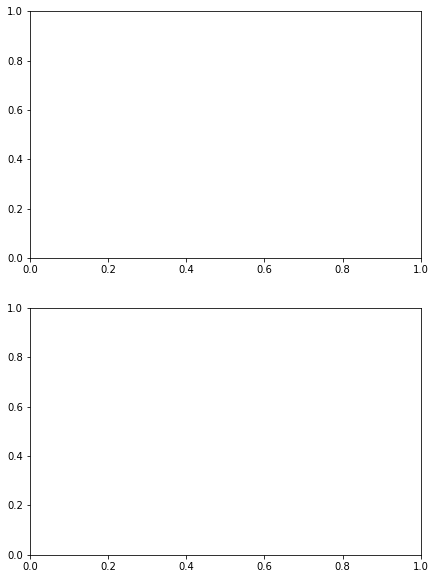

In [40]:
shear_predicted_constants_ann = pd.DataFrame(columns = ['Sample', 'z_shear', 'n', 'tau'])
for sid in shear_ids:
    # s_test = shear_test(shear_samps, samp_num)
    # XX_ex, M_ex_og,S_ex,T_ex_og = s_test['data_in']
    # shear_exp = s_test[''][0]
    # log_visc_exp = np.power(10,s_test['known'][1])
    # #XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
    # XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
    # M_ex = M_scaler.transform(np.power(10, M_ex_og))
    # S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
    # T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    # y_ax = (3,5)
    # temps = [-50, -20, 20, 50]
    ###
    extrap_tests = shear_test(shear_samps, sid)
    XX_ex, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    sample = extrap_tests['sample']
    # get the actual experimental values of  the trial
    try:
        log_visc_ex = np.power(10,extrap_tests['exp'][1])[~np.isnan(np.power(10,extrap_tests['exp'][1]))]
        shear_exp = np.power(10,extrap_tests['exp'][0])[~np.isnan((extrap_tests['exp'][1]))]
        P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
        P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    except:
        print(f'Test failed for {sample}.')
        continue
    #The inputs for the ML model to predict
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(np.power(10,M_ex_og))
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    #test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])


    fig = plt.figure(figsize = (7,10))
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    ax = [ax1, ax2]
    tick = 0
    test_pred, test_var,_ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_ex, P_ex])
    
    l = shear_exp.shape[0]
    exp_pred, _,_ = predict_all_cv(models_f[0],[XX_ex[:l], M_ex[:l], S_scaler.transform(S_trans.transform(np.array(shear_exp).reshape(-1,1))), T_ex[:l], P_exp])
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
  
    
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    # a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))
    # predicted_constants_ann = pd.concat([predicted_constants_ann, pd.DataFrame({'Polymer': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

    fig.suptitle('Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
    # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    # ax[0].text(5, 3, r'$\alpha_2=$' + "{:1.4f}".format(a2))
    # ax[0].text(5, 2, r'$k_2=$' + "{:1.4f}".format(k2))
    # ax[0].text(5, 1, r'$Mcr=$' + "{:1.4f}".format(Mcr))
    # ax[0].text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a1))
    # ax[0].text(2.5, 3, r'$k_1=$' + "{:1.4f}".format(k1))

    for temp_test in [False, True]:    
        ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
        ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
        # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
        # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
        # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
        ax[tick].scatter(np.log10(shear_exp), log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
        ax[tick].axis(ymin = min(log_visc_ex) - 2.5, ymax = max(log_visc_ex) + 2)
        
        #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
        #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


        ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
        ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        if temp_test:
            for i in temps:
                test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex])
                test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
                test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
                ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
                ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        ax[tick].legend()
        tick += 1
    
    plt.savefig(f'Extrapolation_Tests/{date}_{data_type}/shear/ANN/{sample}.jpg', bbox_inches='tight')
    plt.close(fig)

ValueError: When input_signature is provided, all inputs to the Python function must be convertible to tensors:
  inputs: (
    [array([[0.21428571, 0.28125   , 0.10416667, ..., 0.        , 0.        ,
        0.        ],
       [0.21428571, 0.28125   , 0.10416667, ..., 0.        , 0.        ,
        0.        ],
       [0.21428571, 0.28125   , 0.10416667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.21428571, 0.28125   , 0.10416667, ..., 0.        , 0.        ,
        0.        ],
       [0.21428571, 0.28125   , 0.10416667, ..., 0.        , 0.        ,
        0.        ],
       [0.21428571, 0.28125   , 0.10416667, ..., 0.        , 0.        ,
        0.        ]]), array([[0.00995142],
       [0.02453485],
       [0.05548514],
       [0.11988659],
       [0.21447142],
       [0.33260864],
       [0.44940918],
       [0.62603799],
       [0.80014694],
       [0.85908316],
       [0.50509788]]), array([[0.00023664],
       [0.00037845],
       [0.00060512],
       [0.00096719],
       [0.00154506],
       [0.00246598],
       [0.00393025],
       [0.00624998],
       [0.00990398],
       [0.01560864],
       [0.02439413]]), array([[0.20285377],
       [0.20285377],
       [0.20285377],
       [0.20285377],
       [0.20285377],
       [0.20285377],
       [0.20285377],
       [0.20285377],
       [0.20285377],
       [0.20285377],
       [0.20285377]]), array([[0.09533333],
       [0.09533333],
       [0.09533333],
       [0.09533333],
       [0.09533333],
       [0.09533333],
       [0.09533333],
       [0.09533333],
       [0.09533333],
       [0.09533333],
       [0.09533333]])],
    False,
    False)
  input_signature: (
    TensorSpec(shape=(None, 223), dtype=tf.float64, name=None)).

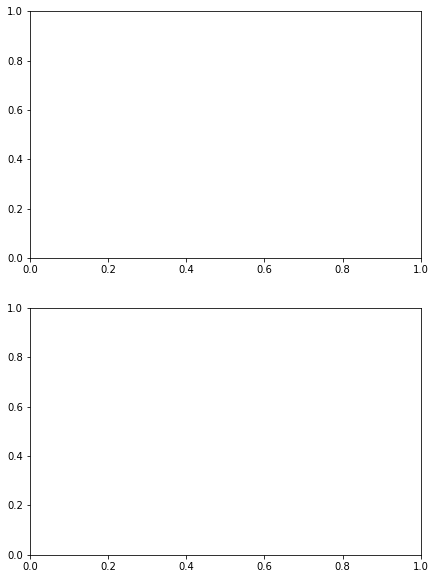

In [50]:
shear_predicted_constants_gpr = pd.DataFrame(columns = ['Sample', 'z_shear', 'n', 'tau'])
for sid in shear_ids:
    # s_test = shear_test(shear_samps, samp_num)
    # XX_ex, M_ex_og,S_ex,T_ex_og = s_test['data_in']
    # shear_exp = s_test[''][0]
    # log_visc_exp = np.power(10,s_test['known'][1])
    # #XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
    # XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
    # M_ex = M_scaler.transform(np.power(10, M_ex_og))
    # S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
    # T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    # y_ax = (3,5)
    # temps = [-50, -20, 20, 50]
    ###
    extrap_tests = shear_test(shear_samps, sid)
    XX_ex, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    sample = extrap_tests['sample']
    # get the actual experimental values of  the trial
    try:
        log_visc_ex = np.power(10,extrap_tests['exp'][1])[~np.isnan(np.power(10,extrap_tests['exp'][1]))]
        shear_exp = np.power(10,extrap_tests['exp'][0])[~np.isnan((extrap_tests['exp'][1]))]
        P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
        P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    except:
        print(f'Test failed for {sample}')
        continue
    #The inputs for the ML model to predict
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(np.power(10,M_ex_og))
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    #test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])


    fig = plt.figure(figsize = (7,10))
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    ax = [ax1, ax2]
    tick = 0
    test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex, T_ex, P_ex), axis = 1))
    l = shear_exp.shape[0]
    exp_pred, _,_ = gpr_models_f[2].predict_f_compiled([XX_ex[:l], S_scaler.transform(S_trans.transform(np.array(shear_exp).reshape(-1,1))), S_ex[:l], T_ex[:l], P_exp])
    exp_pred =  y_scaler.inverse_transform(np.array(exp_pred).reshape(-1, 1)).reshape(-1,)
    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
  
    
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
    # a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))
    # predicted_constants_ann = pd.concat([predicted_constants_ann, pd.DataFrame({'Polymer': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

    fig.suptitle('Shear Visc. ANN Extrapolation: ' + extrap_tests['sample'] + f'\nOME w.r.t. experimental points = {OME(log_visc_ex, exp_pred)}')
    # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
    # ax[0].text(5, 3, r'$\alpha_2=$' + "{:1.4f}".format(a2))
    # ax[0].text(5, 2, r'$k_2=$' + "{:1.4f}".format(k2))
    # ax[0].text(5, 1, r'$Mcr=$' + "{:1.4f}".format(Mcr))
    # ax[0].text(2.5, 4, r'$\alpha_1=$' + "{:1.4f}".format(a1))
    # ax[0].text(2.5, 3, r'$k_1=$' + "{:1.4f}".format(k1))

    for temp_test in [False, True]:    
        ax[tick].set_xlabel(r'$Log M_w$ (g/mol)')
        ax[tick].set_ylabel(r'$Log \eta_o$ (Poise)')
        # a_1, a_2 = calc_slopes_Mw(M_scaler.inverse_transform(M_ex),test_pred)
        # ax[tick].text(5, 1, r'$\alpha_2=$' + "{:1.4f}".format(a_2[0]))
        # ax[tick].text(2.5, 1, r'$\alpha_1=$' + "{:1.4f}".format(a_1[0]))
        ax[tick].scatter(np.log10(shear_exp), log_visc_ex, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
        ax[tick].axis(ymin = y_ax[0], ymax = y_ax[1])
        
        #plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
        #plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]} C')


        ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0]} C')
        ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        if temp_test:
            for i in temps:
                test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex, T_scaler.transform(1/(T_ex_og +273.15 + i)), P_ex])
                test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
                test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
                ax[tick].plot(np.log10(S_ex_og), test_pred.reshape(-1,), '--',label = f'Prediction at {T_ex_og[0][0] + i} C')
                ax[tick].fill_between(np.log10(S_ex_og).reshape(-1,), test_pred.reshape(-1,) - test_var.reshape(-1,), test_pred.reshape(-1,) + test_var.reshape(-1,), alpha = 0.3 )

        ax[tick].legend()
        tick += 1
    
    plt.savefig(f'Extrapolation_Tests/{date}_{data_type}/shear/GPR/{sample}.jpg', bbox_inches='tight')
    plt.close(fig)

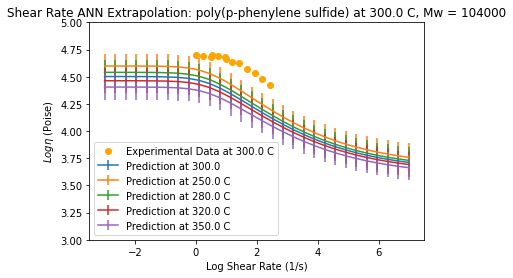

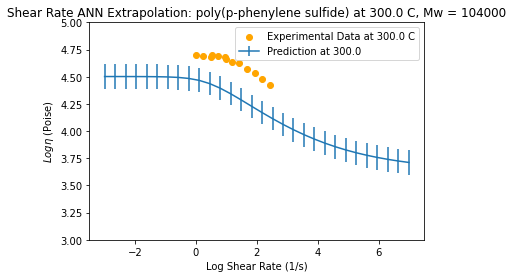

In [326]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
for temp_test in [True, False]:
    test_pred, test_var,_ = predict_all_cv(models_f[0], [XX_ex, M_ex, S_ex_trans, T_ex])
    shear = [s[0] for s in np.log10(S_ex)]

    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)

    plt.figure()
    plt.errorbar(shear, test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0]}')
    plt.title('Shear Rate ANN Extrapolation: ' + s_test['sample'])

    if temp_test:
        for i in temps:
            test_pred, test_var, _ = predict_all_cv(models_f[0],[XX_ex, M_ex, S_ex_trans, T_scaler.transform(1/(T_ex_og +273.15 + i))])
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            plt.errorbar(shear, test_pred, yerr= test_var,  label = f'Prediction at {T_ex_og[0][0] + i} C')
    plt.xlabel('Log Shear Rate (1/s)')
    plt.ylabel(r'$Log \eta$ (Poise)')
    plt.scatter(shear_exp, log_visc_exp, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')

    plt.legend()
    plt.ylim(*y_ax)

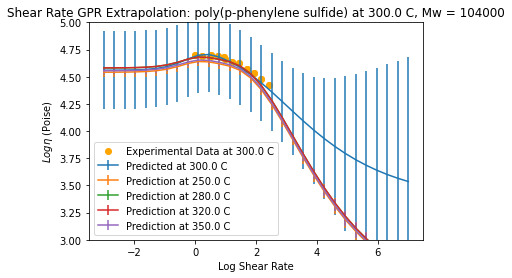

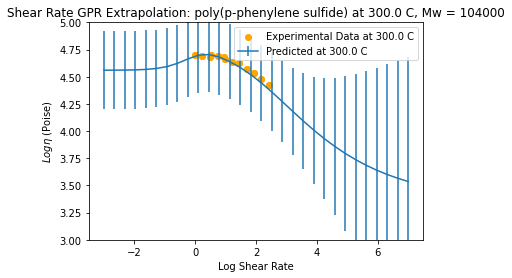

In [330]:
#test_pred, test_var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
for temp_test in [True, False]:
    if model_reloaded:
        test_pred, var = gpr_models_f[1].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
    else:
        test_pred, var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
    test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
    var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)



    plt.figure()

    plt.errorbar(shear, test_pred, yerr= var, label = f'Predicted at {T_ex_og[0][0]} C')
    if temp_test:
        for i in temps:
            test_pred, test_var = gpr_models_f[2].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex_trans, T_scaler.transform(1/(T_ex_og +273.15 + i))), axis = 1))
            test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
            test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
            plt.errorbar(shear, test_pred, yerr= test_var, label = f'Prediction at {T_ex_og[0][0] + i} C')

    plt.xlabel('Log Shear Rate (1/s)')
    plt.ylabel(r'$Log \eta$ (Poise)')
    plt.scatter(shear_exp, log_visc_exp, c = 'orange')




    plt.title('Shear Rate GPR Extrapolation: '+ s_test['sample'])

    plt.xlabel('Log Shear Rate')
    plt.ylabel(r'$Log \eta$ (Poise)')
    plt.scatter(shear_exp, log_visc_exp, c = 'orange', label = f'Experimental Data at {T_ex_og[0][0]} C')
    plt.ylim(*y_ax)
    plt.legend()

In [144]:
#test_pred = m_P.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
test_pred, test_var,_ = predict_all_cv(models_f[1],[XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in np.log10(S_ex)]

test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
if temp_test:
    for i in [1,3,5]:
        test_pred, test_var,_ = predict_all_cv(models_f[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]])])
        test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
        test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Log Shear Rate (1/s)')
plt.ylabel(r'$Log \eta$ (Poise)')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
#plt.plot(np.log10(S_ex[:-1]), test_pred[:-1])
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
     plt.legend(['Experimental','Predicted'])
plt.title('Physics NN Extrapolation')
plt.ylim(*y_ax)

plt.figure()
plt.scatter(shear_exp, log_visc_exp, c = 'orange')

#print(params_layer([XX_ex, M_ex, S_ex_trans, T_ex]))
#z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex])
#print(crit_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(tau_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(n_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))

NameError: name 'models' is not defined

Shear with Low and Zero Shear Rates

In [358]:
low_shear_samps = shear_samps.copy()
for samp in shear_ids:
    if np.prod(low_shear_samps.loc[low_shear_samps['SAMPLE_ID'] == samp, 'Shear_Rate']) != 0:
        low_shear_samps = low_shear_samps.drop(low_shear_samps.loc[low_shear_samps['SAMPLE_ID'] == samp].index, axis = 0)
low_shear_ids = list(low_shear_samps.agg({'SAMPLE_ID': 'unique'})[0])

In [359]:
low_shear_samps.index

Int64Index([ 341,  342,  343,  344,  345,  346,  347,  348,  349,  350,
            ...
            1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358],
           dtype='int64', length=143)

In [379]:
samp_num = low_shear_ids[4]
s_test = small_shear_test(low_shear_samps, samp_num)
XX_ex, M_ex,S_ex,T_ex = s_test['data_in']
shear_exp = s_test['known'][0]
log_visc_exp = np.power(10,s_test['known'][1])
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
M_ex = M_scaler.transform(np.power(10, M_ex))
S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(1/(T_ex+273.15))
temp_test = False
y_ax = (1,4)

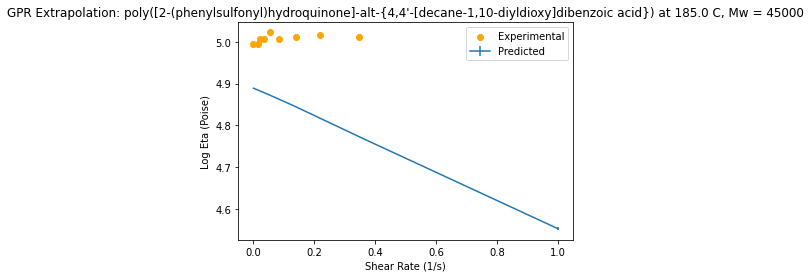

In [382]:
test_pred, test_var = gpr_models_f[3].predict_f_compiled(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
shear = [s[0] for s in S_ex]

test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)

plt.figure()
plt.title('GPR Extrapolation: ' + s_test['sample'])
plt.errorbar(shear, np.array(test_pred).tolist(), yerr= np.array(test_var).tolist()) #[i[0] for i in np.array(test_var).tolist()]
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
plt.legend(['Experimental','Predicted'])

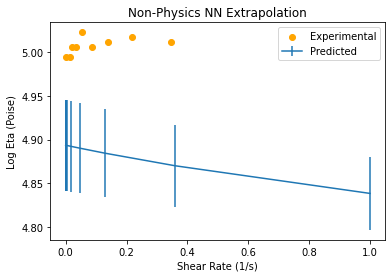

In [381]:
test_pred, test_var,_ = predict_all_cv(models_f[0], [XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in S_ex]

test_pred = y_scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(-1,)
test_var = (y_scaler.inverse_transform(np.array(test_var).reshape(-1, 1)) - y_scaler.data_min_).reshape(-1,)


plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Non-Physics NN Extrapolation')

# if temp_test:
#     for i in [1,3,5]:
#         test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
#         plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])

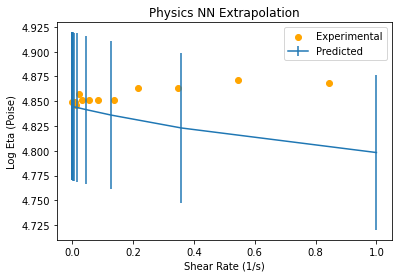

In [367]:
test_pred, test_var,_ = predict_all_cv(models[1], [XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in S_ex]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Physics NN Extrapolation')

if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp[np.where(shear_exp < 1)], log_visc_exp[np.where(shear_exp < 1)], c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])

Holistic Model Performance

In [46]:
os.listdir('Extrapolation_Tests/2022-03-23_full/Mw/ANN')

['cis-1,4-poly(2-methyl-1,3-pentadiene) at 75.0 C.jpg',
 'polyisobutylene at 25.0 C.jpg',
 'poly(prop-1-ene) at 200.0 C.jpg',
 'polybutadiene at 49.0 C.jpg',
 'polyisobutylene at 217.0 C.jpg',
 'hydrogenated polyisoprene at 130.0 C.jpg',
 'polybutadiene at -2.0 C.jpg',
 'polyethersulfone at 240.0 C.jpg',
 'polypropylene at 75.0 C.jpg',
 'polyisobutylene at 175.0 C.jpg',
 'polypropylene at 200.0 C.jpg',
 'polybutadiene at -28.0 C.jpg',
 'poly(dimethylsiloxane) at 20.0 C.jpg',
 'hydrogenated polyisoprene at 75.0 C.jpg',
 'polypropylene at 180.0 C.jpg',
 'polyisobutylene at 200.0 C.jpg',
 'polybutadiene at 25.0 C.jpg',
 'cis-1,4-polyisoprene at 75.0 C.jpg',
 'Linear HDPE at 150.0 C.jpg',
 'hydrogenated polyisoprene at 100.0 C.jpg',
 'polystyrene at 190.0 C.jpg',
 'poly(decamethylene adipate) at 109.0 C.jpg',
 'poly[(butane-1,4-diol)-alt-(isophthalic acid)], poly(oxybutane-1,4-diyloxy{5-[(sodiooxy)sulfonyl]isophthaloyl}) at 200.0 C.jpg',
 'poly[oxy(1,1,2,2,3,3-hexafluoropropane-1,3-diyl)] 

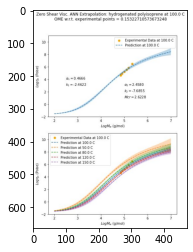

In [48]:
img = plt.imread('Extrapolation_Tests/2022-03-23_full/Mw/ANN/hydrogenated polyisoprene at 100.0 C.jpg')
plt.imshow(img)